# Course project


## **Основное**
- Дедлайн - 31 мая 23:59
- Целевая метрика precision@5 > 0.235
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. В решении должны быть отчетливо видна метрика на новом тестовом сете из файла retail_test1.csv, то есть вам нужно для всех юзеров из этого файла выдать выши рекомендации, и посчитать на actual покупках precision@5. 

**!! Мы не рассматриваем холодный старт для пользователя, все наши пользователя одинаковы во всех сетах, поэтому нужно позаботиться об их исключении из теста.**


**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 

In [1]:
#!pip install implicit==0.4.4

# Import libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [647]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# Set global const

In [648]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 50 

# Process features dataset

In [649]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [650]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [651]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [652]:
# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [653]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [654]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [655]:
# выше видим разброс по пользователям и товарам и дальше мы перейдем к warm-start (только известные пользователи)

In [656]:
data_val_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


# Pre- Prefilter items


In [657]:
for_top = data[['item_id', 'sales_value']].copy()

In [658]:
for_top = for_top.groupby('item_id',as_index=False).agg('sum').rename(columns={'sales_value': 'top_sales'})

In [659]:
for_top[for_top['top_sales'] > for_top['top_sales'].quantile(.96)].count()

item_id      3562
top_sales    3562
dtype: int64

# Prefilter items

In [660]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=3562)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\lufta\Documents\course_project\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 3563


# Make cold-start to warm-start

In [661]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 3563
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


# Init/train recommender

In [662]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3563 [00:00<?, ?it/s]

# Eval recall of matching

In [663]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


### N_PREDICT

In [664]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model, N_PREDICT, col_name):
    result_col_name = col_name
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N_PREDICT))
    return col_name, df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [665]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [666]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [667]:
def selection(n_list):
    selection_df = pd.DataFrame()
    for n in n_list:
        recall = evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations, n, 'recall')
        selection_df = selection_df.append(pd.DataFrame([recall[1]], columns=['recall'], index=[n]))
    return selection_df

In [668]:
n_list = [10, 20, 50, 100, 200, 250, 300, 400, 500]

In [669]:
selection_df = selection(n_list)

In [670]:
selection_df['growth'] = (selection_df['recall'] - selection_df['recall'].shift(1)).fillna(0)
selection_df['growth_%'] = ((selection_df['recall'] / selection_df['recall'].shift(1))-1).fillna(0)

In [671]:
selection_df

,recall,growth,growth_%
10,0.028166,0.000000,0.000000
20,0.042371,0.014205,0.504330
50,0.069158,0.026787,0.632209
100,0.101310,0.032151,0.464897
200,0.136738,0.035428,0.349702
250,0.147800,0.011062,0.080900
300,0.154926,0.007126,0.048213
400,0.167564,0.012638,0.081577
500,0.176386,0.008822,0.052646


<AxesSubplot:>

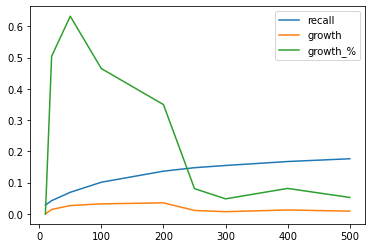

In [672]:
selection_df.plot()

In [673]:
N_PREDICT = 200 

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [674]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [675]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [676]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [677]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 944588, 1092937, 917033, 10198378, 8..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [678]:
# разворачиваем товары
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [679]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [680]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,944588
0,2070,1092937
0,2070,917033


### Check warm start

In [681]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (430200, 2) Users: 2151 Items: 3445


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [682]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [683]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [684]:
df_ranker_train.target.value_counts()

0.0    391451
1.0     18585
Name: target, dtype: int64

In [685]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,944588,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [686]:
df_ranker_train['target'].mean()

0.04532528851125267

1) Pointwise
2) Pairwise
3) ListWise

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

### Описательные фичи

In [687]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [688]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [689]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Поведенческие фичи

##### Чтобы считать поведенческие фичи, нужно учесть все данные что были до data_val_ranker

In [690]:
df_join_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [691]:
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


## my features

In [692]:
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('sales_value').sum().rename('user_item_sales_value'), how='left',on=[USER_COL, ITEM_COL])

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('quantity').sum().rename('user_item_quantity'), how='left',on=[USER_COL, ITEM_COL])

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('quantity').sum().rename('user_item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=[USER_COL, ITEM_COL])

In [693]:
df_join_train_matcher_full = df_join_train_matcher.merge(item_features, on='item_id', how='left')
df_join_train_matcher_full = df_join_train_matcher_full.merge(user_features, on='user_id', how='left')

In [694]:
df_ranker_train = df_ranker_train.merge(df_join_train_matcher_full.groupby(by=[USER_COL, 'commodity_desc']).agg('quantity').sum().rename('user_desc_quantity'), how='left',on=[USER_COL, 'commodity_desc'])

df_ranker_train = df_ranker_train.merge(df_join_train_matcher_full.groupby(by=[USER_COL, 'commodity_desc']).agg('quantity').sum().rename('user_desc_quantity_for_week')/df_join_train_matcher_full.week_no.nunique(), how='left',on=[USER_COL, 'commodity_desc'])

In [695]:
df_ranker_train = df_ranker_train.fillna(0)

In [696]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket,user_item_sales_value,user_item_quantity,user_item_quantity_per_week,user_desc_quantity,user_desc_quantity_for_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,1218.32967,0.000461,0.452137,0.000404,0.00814,27.93,7.0,0.076923,14.0,0.153846
1,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,1218.32967,0.000306,0.452137,0.000273,0.00814,14.67,4.0,0.043956,38.0,0.417582


In [697]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [698]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('str')

## Обучение модели ранжирования

In [699]:
from catboost import CatBoostRegressor, CatBoost

In [700]:
def init_model(component, los, regular, item, user):
    model = CatBoostRegressor(objective='binary',
                                iterations = iterations,
                                learning_rate=learning_rate, 
                                depth=depth,
                                l2_leaf_reg=l2_leaf_reg)       
    return model

def fit_model(model):
    return model.fit(X_train, y_train,
                    cat_features=cat_feats,
                    eval_set=(X_test, y_test),
                    verbose=False)     

def predict_model(model):
    predictions = model.predict(X_test)
    return predictions

In [701]:
cat = CatBoostRegressor(cat_features=cat_feats, logging_level='Silent')

grid = {
    'learning_rate': [0.03],
    'iterations':[100, 200, 500],
    'depth': [2, 3, 4],
    'l2_leaf_reg': [3, 5, 7]
}

#cat.grid_search(grid, X=X_train, y=y_train, plot=True)

In [702]:
cat = CatBoostRegressor(cat_features=cat_feats,
                       learning_rate=0.03, iterations = 600,
                       depth = 2, l2_leaf_reg = 5)

In [703]:
cat.fit(X_train, y_train, logging_level='Silent')

In [704]:
train_preds = cat.predict(X_train)

In [705]:
df_ranker_predict = df_ranker_train.copy()

In [706]:
df_ranker_predict['proba_item_purchase'] = train_preds

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [707]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [708]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 6.36 s


In [709]:
TOPK_PRECISION = 5

In [710]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.15284313725490042)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [711]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [712]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

## Проверьте данные метрики с фичами и без (PS: должен быть прирост)

In [713]:
# смотрим на метрики выше и сравниваем что с ранжированием и без, добавляем фичи и то же смотрим
# в первом приближении метрики должны расти с использованием второго этапа

print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.3207310704960834)
('own_rec', 0.15284313725490042)


C:\Users\lufta\Documents\course_project\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


# Оценка на тесте для выполнения курсового проекта

In [714]:
# df_transactions = pd.read_csv('../data/transaction_data.csv')

In [715]:
df_test = pd.read_csv('retail_test1.csv')

In [716]:
df_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [717]:
result_test = df_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

# Считаем precision@5 по новому тесту

In [718]:
result_test['reranked_own_rec'] = result_test[USER_COL].apply(lambda user_id: rerank(user_id))

In [719]:
print(*sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.26362612612612396)


C:\Users\lufta\Documents\course_project\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
